In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import emcee

In [2]:
font = {'size'   : 15, 'family':'sans-serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

In [3]:
def read_chains_backends(chainfiles):
    all_chains = []
    all_best_samples = []
    all_log_probs = []

    for chainfile in chainfiles:
        reader = emcee.backends.HDFBackend(chainfile)
        samples_input = reader.get_chain()
        burnin = int(len(samples_input) * 0.45)
        
        chain = reader.get_chain(discard=burnin, flat=True, thin=1)
        all_chains.append(chain)

        #log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=1)
        #bestid = np.argmax(log_prob_samples)
        #best_sample = copy.copy(samples_input[bestid])
        #all_best_samples.append(best_sample)
        #all_log_probs.append(log_prob_samples)

    return np.array(all_chains)[0]

In [4]:
def get_stats_chains(chains, percentile=0.6827):
    """
    Calculate statistics for each chain in a list of chains.

    Parameters:
    chains (list of numpy arrays): List of chains, where each chain is a 2D numpy array.
    percentile (float): Desired percentile for calculating sigma ranges. Default is 0.6827.

    Returns:
    list of dictionaries: List containing dictionaries with calculated statistics for each chain.
    """
    
    results = []

    for chain in chains:
        n_params = chain.shape[1]
        stats = {'median': [], 'sigma-': [], 'sigma+': [], 'mean': [], 'sigma': []}

        for i in range(n_params):
            data = chain[:, i]
            nb_x = len(data)
            ind_inf = int(np.floor(nb_x * (0.5 - percentile/2)))
            ind_sup = int(np.ceil(nb_x * (0.5 + percentile/2)))
            ind_med = int(np.round(nb_x * 0.5))
            data_sorted = np.sort(data)
            stats['median'].append(data_sorted[ind_med])
            stats['sigma-'].append(data_sorted[ind_inf] - data_sorted[ind_med])
            stats['sigma+'].append(data_sorted[ind_sup] - data_sorted[ind_med])
            stats['mean'].append(np.mean(data))
            stats['sigma'].append(np.std(data))

        results.append(stats)

    return results

In [5]:
def plot_triangular_chains(chains_and_labels, filled, contour_ls, contour_lws,
                           legend_labels, contour_colors, markers, params_to_show=None,
                           title=None, fontsize_title=None, title_x=None, title_y=None,
                           save_path=None, smoothing=False, params_ranges=None,
                           legend_fontsize = 16, axes_labelsize=22, axes_fontsize=16, 
                           legend_x = 0, legend_y = 0.8, alpha_filled=0.8, marker_color = 'k'):
    '''
    Generate a triangular plot for multiple chains of samples.

    Args:
        chains_and_labels (list of tuples): List of tuples where each tuple contains a numpy array representing the sample chain and its corresponding labels.
        filled (list): List of True or False for filled contours or not.
        contour_ls (list): List of line styles: '-', '--', '-.', ':'.
        contour_lws (list): List of line widths.
        legend_labels (list): Labels for the legends of each chain.
        contour_colors (list): List of colors to be used.
        markers (list): List of markers for each chain.
        params_to_show (list, optional): List of parameters to be shown in the plot. Default is None.
        title (str, optional): Title of the plot. Default is None.
        fontsize_title (float, optional): Font size for the plot title.
        title_x (float, optional): x-coordinate of the plot title.
        title_y (float, optional): y-coordinate of the plot title.
        save_path (str, optional): Path to save the plot image. Default is None.
        smoothing (bool, optional): Whether to apply smoothing to the samples. Default is False.
        params_ranges (dict, optional): Dictionary with parameter names as keys and corresponding ranges as values.

    Returns:
        A beautiful triangular plot.
    '''

    # Create MCSamples instances for each chain and its labels
    samples = []
    for chain, labels in chains_and_labels:
        ranges = {}
        if params_ranges:
            for param, param_range in params_ranges.items():
                ranges[param] = param_range
        sample_instance = MCSamples(samples=chain, names=labels, ranges=ranges)
        samples.append(sample_instance)

    # If params_to_show is not provided, show all parameters
    if params_to_show is None:
        params_to_show = [labels for _, labels in chains_and_labels]

    # Apply smoothing if specified
    if smoothing:
        samples_smooth = [s.copy(settings={'mult_bias_correction_order': 1,
                                           'smooth_scale_2D': 0.7,
                                           'smooth_scale_1D': 0.7}) for s in samples]
    else:
        samples_smooth = samples

    # Plot settings
    g = plots.get_subplot_plotter()
    g.settings.figure_legend_frame = False
    g.settings.alpha_filled_add = alpha_filled
    g.settings.legend_fontsize = legend_fontsize #16 #18
    g.settings.axes_labelsize = axes_labelsize  #22
    g.settings.axes_fontsize = axes_fontsize #16
    g.settings.axis_marker_color = marker_color
    g.settings.axis_marker_lw = 1.2

    # Generate the triangular plot with selected parameters
    g.triangle_plot(samples_smooth, params_to_show,
                    filled=filled,
                    contour_ls=contour_ls,
                    contour_lws=contour_lws,
                    legend_labels=legend_labels,
                    legend_loc=(legend_x, legend_y),#'upper right',
                    contour_colors=contour_colors,
                    markers=markers,
                    line_args=[{'ls': ls, 'lw': lw, 'color': color} for ls, lw, color in zip(contour_ls, contour_lws, contour_colors)])

    # Add title to the plot
    if title:
        plt.suptitle(title, fontsize=fontsize_title, x=title_x, y=title_y)

    # Save the plot to the specified path
    if save_path:
        plt.savefig(save_path, bbox_inches = 'tight')

    # Show the plot
    plt.show()

In [6]:
def plot_1D_marginals(chains_and_labels, filled, contour_ls, contour_lws,
                           legend_labels, contour_colors, markers, params_to_show=None,
                           title=None, fontsize_title=None, title_x=None, title_y=None,
                           share_y=True, nx=3, legend_ncol=2,
                           save_path=None, smoothing=False, params_ranges=None, width_inch=10, legend_fontsize=12,
                           axes_labelsize =12, alpha_filled = 0.8, marker_color='k'):
    '''
    Generate a triangular plot for multiple chains of samples.

    Args:
        chains_and_labels (list of tuples): List of tuples where each tuple contains a numpy array representing the sample chain and its corresponding labels.
        filled (list): List of True or False for filled distributions or not. (...in construction...)
        contour_ls (list): List of line styles: '-', '--', '-.', ':'.
        contour_lws (list): List of line widths.
        legend_labels (list): Labels for the legends of each chain.
        contour_colors (list): List of colors to be used.
        markers (list): List of markers for each chain.
        params_to_show (list, optional): List of parameters to be shown in the plot. Default is None.
        title (str, optional): Title of the plot. Default is None.
        fontsize_title (float, optional): Font size for the plot title.
        title_x (float, optional): x-coordinate of the plot title.
        title_y (float, optional): y-coordinate of the plot title.
        share_y (bool): Whether to share the y-axis. Default is True.
        nx (int): Number of subplots in the x-axis. Default is 3.
        legend_ncol (int): Number of columns in the legend. Default is 2.
        save_path (str, optional): Path to save the plot image. Default is None.
        smoothing (bool, optional): Whether to apply smoothing to the samples. Default is False.
        params_ranges (dict, optional): Dictionary with parameter names as keys and corresponding ranges as values.

    Returns:
        beautiful 1D plots.
    '''

    # Create MCSamples instances for each chain and its labels
    samples = []
    for chain, labels in chains_and_labels:
        ranges = {}
        if params_ranges:
            for param, param_range in params_ranges.items():
                ranges[param] = param_range
        sample_instance = MCSamples(samples=chain, names=labels, ranges=ranges)
        samples.append(sample_instance)

    # If params_to_show is not provided, show all parameters
    if params_to_show is None:
        params_to_show = [labels for _, labels in chains_and_labels]

    # Apply smoothing if specified
    if smoothing:
        samples_smooth = [s.copy(settings={'mult_bias_correction_order': 1,
                                           'smooth_scale_2D': 0.7,
                                           'smooth_scale_1D': 0.7}) for s in samples]
    else:
        samples_smooth = samples

    # Plot settings
    g = plots.get_subplot_plotter(width_inch=width_inch)
    g.settings.figure_legend_frame = False
    g.settings.alpha_filled_add = alpha_filled
    g.settings.legend_fontsize = legend_fontsize #14
    g.settings.axes_labelsize = axes_labelsize #19
    g.settings.axes_fontsize = 16
    g.settings.axis_marker_color = marker_color
    g.settings.axis_marker_lw = 1.2
    
    
    # Generate the 1D plots with selected parameters
    g.plots_1d(samples_smooth, params_to_show,
               share_y=share_y, filled=filled,
               contour_ls=contour_ls,
               contour_lws=contour_lws,
               #legend_labels=legend_labels,
               #legend_loc='upper right',
               contour_colors=contour_colors,
               markers=markers,
               nx=nx, #legend_ncol=legend_ncol,
               line_args=[{'ls': ls, 'lw': lw, 'color': color} for ls, lw, color in zip(contour_ls, contour_lws, contour_colors)]
              )
    
    g.add_legend(legend_labels, legend_loc='upper right', colored_text=True);

    # Add title to the plot
    if title:
        plt.suptitle(title, fontsize=fontsize_title, x=title_x, y=title_y)

    # Save the plot to the specified path
    if save_path:
        plt.savefig(save_path)

    # Show the plot
    plt.show()

In [7]:
def newchain_Folps(chain, ndim, omega_ndcm = 0.00064420):
    
    chain_new = np.zeros((len(chain), len(chain[1]) + 1))
    
    for ii in range(len(chain)):
        for jj in range(len(chain[1])):
            chain_new[ii][jj] = chain[ii][jj]
            
        chain_new[ii][ndim] = (chain[ii][1] + chain[ii][2] + omega_ndcm)/chain[ii][0]**2

    return chain_new

In [8]:
def newchain_Vel(chain, ndim):
    
    chain_new = np.zeros((len(chain), len(chain[1]) + 1))
    
    for ii in range(len(chain)):
        for jj in range(len(chain[1])):
            chain_new[ii][jj] = chain[ii][jj]
            
        chain_new[ii][ndim] = chain[ii][2]/100

    return chain_new

# Triangular plots

In [9]:
######################### READING CHAIN #####################################

path_LRG = 'Chains/LRG/'
path_ELG = 'Chains/ELG/'
path_QSO = 'Chains/QSO/'
path_LRG_ELG = 'Chains/Joint_LRG_ELG/'
path_ALL = 'Chains/Joint_LRG_ELG_QSO/'



################################### V5 and Max F ########################################

chain_MaxF_V5_LRG = read_chains_backends(chainfiles=[path_LRG+'Chain_FS_LRGs_MaxF_V5.h5'])
chain_MaxF_V5_LRG = newchain_Folps(chain=chain_MaxF_V5_LRG, ndim=8)
print(chain_MaxF_V5_LRG.shape)


chain_MaxF_V5_ELG = read_chains_backends(chainfiles=[path_ELG+'Chain_FS_ELGs_MaxF_V5.h5'])
chain_MaxF_V5_ELG = newchain_Folps(chain=chain_MaxF_V5_ELG, ndim=8)
print(chain_MaxF_V5_ELG.shape)


chain_MaxF_V5_QSO = read_chains_backends(chainfiles=[path_QSO+'Chain_FS_QSOs_MaxF_V5.h5'])
chain_MaxF_V5_QSO = newchain_Folps(chain=chain_MaxF_V5_QSO, ndim=8)
print(chain_MaxF_V5_QSO.shape)


chain_MaxF_V5_LRG_ELG = read_chains_backends(chainfiles=[path_LRG_ELG+'Chain_FM_Joint_LRGz0p8_ELGz1p1_Cov5_MaxF_kmax018_l02_Marg.h5'])
chain_MaxF_V5_LRG_ELG = newchain_Folps(chain=chain_MaxF_V5_LRG_ELG, ndim=12)
print(chain_MaxF_V5_LRG_ELG.shape)


chain_MaxF_V5_ALL = read_chains_backends(chainfiles=[path_ALL+'Chain_FM_Joint_LRGz0p8_ELGz1p1_QSOz1p4_Cov5_MaxF_kmax018_l02_Marg.h5'])
chain_MaxF_V5_ALL = newchain_Folps(chain=chain_MaxF_V5_ALL, ndim=16)
print(chain_MaxF_V5_ALL.shape)

(388960, 9)
(184800, 9)
(251680, 9)
(712080, 13)
(1094048, 17)


In [10]:
################################### V5 and Min F ########################################

chain_MinF_V5_LRG = read_chains_backends(chainfiles=[path_LRG+'Chain_FS_LRGs_MinF_V5.h5'])
chain_MinF_V5_LRG = newchain_Folps(chain=chain_MinF_V5_LRG, ndim=6)
print(chain_MinF_V5_LRG.shape)


chain_MinF_V5_ELG = read_chains_backends(chainfiles=[path_ELG+'Chain_FS_ELGs_MinF_V5.h5'])
chain_MinF_V5_ELG = newchain_Folps(chain=chain_MinF_V5_ELG, ndim=6)
print(chain_MinF_V5_ELG.shape)


chain_MinF_V5_QSO = read_chains_backends(chainfiles=[path_QSO+'Chain_FS_QSOs_MinF_V5.h5'])
chain_MinF_V5_QSO = newchain_Folps(chain=chain_MinF_V5_QSO, ndim=6)
print(chain_MinF_V5_QSO.shape)


chain_MinF_V5_LRG_ELG = read_chains_backends(chainfiles=[path_LRG_ELG+'Chain_FM_Joint_LRGz0p8_ELGz1p1_Cov5_MinF_kmax018_l02_Marg.h5'])
chain_MinF_V5_LRG_ELG = newchain_Folps(chain=chain_MinF_V5_LRG_ELG, ndim=8)
print(chain_MinF_V5_LRG_ELG.shape)


chain_MinF_V5_ALL = read_chains_backends(chainfiles=[path_ALL+'Chain_FM_Joint_LRGz0p8_ELGz1p1_QSOz1p4_Cov5_MinF_kmax018_l02_Marg.h5'])
chain_MinF_V5_ALL = newchain_Folps(chain=chain_MinF_V5_ALL, ndim=10)
print(chain_MinF_V5_ALL.shape)

(106920, 7)
(113520, 7)
(100980, 7)
(166320, 9)
(245300, 11)


In [11]:
################################### V25 and Max F ########################################

chain_MaxF_V25_LRG = read_chains_backends(chainfiles=[path_LRG+'Chain_FS_LRGs_MaxF_V25.h5'])
chain_MaxF_V25_LRG = newchain_Folps(chain=chain_MaxF_V25_LRG, ndim=8)
print(chain_MaxF_V25_LRG.shape)


chain_MaxF_V25_ELG = read_chains_backends(chainfiles=[path_ELG+'Chain_FS_ELGs_MaxF_V25.h5'])
chain_MaxF_V25_ELG = newchain_Folps(chain=chain_MaxF_V25_ELG, ndim=8)
print(chain_MaxF_V25_ELG.shape)


chain_MaxF_V25_QSO = read_chains_backends(chainfiles=[path_QSO+'Chain_FS_QSOs_MaxF_V25.h5'])
chain_MaxF_V25_QSO = newchain_Folps(chain=chain_MaxF_V25_QSO, ndim=8)
print(chain_MaxF_V25_QSO.shape)


chain_MaxF_V25_LRG_ELG = read_chains_backends(chainfiles=[path_LRG_ELG+'Chain_FM_Joint_LRGz0p8_ELGz1p1_Cov25_MaxF_kmax018_l02_Marg.h5'])
chain_MaxF_V25_LRG_ELG = newchain_Folps(chain=chain_MaxF_V25_LRG_ELG, ndim=12)
print(chain_MaxF_V25_LRG_ELG.shape)


chain_MaxF_V25_ALL = read_chains_backends(chainfiles=[path_ALL+'Chain_FM_Joint_LRGz0p8_ELGz1p1_QSOz1p4_Cov25_MaxF_kmax018_l02_Marg.h5'])
chain_MaxF_V25_ALL = newchain_Folps(chain=chain_MaxF_V25_ALL, ndim=16)
print(chain_MaxF_V25_ALL.shape)

(202928, 9)
(204416, 9)
(207792, 9)
(707232, 13)
(1088128, 17)


In [12]:
################################### V25 and Min F ########################################

chain_MinF_V25_LRG = read_chains_backends(chainfiles=[path_LRG+'Chain_FS_LRGs_MinF_V25.h5'])
chain_MinF_V25_LRG = newchain_Folps(chain=chain_MinF_V25_LRG, ndim=6)
print(chain_MinF_V25_LRG.shape)


chain_MinF_V25_ELG = read_chains_backends(chainfiles=[path_ELG+'Chain_FS_ELGs_MinF_V25.h5'])
chain_MinF_V25_ELG = newchain_Folps(chain=chain_MinF_V25_ELG, ndim=6)
print(chain_MinF_V25_ELG.shape)


chain_MinF_V25_QSO = read_chains_backends(chainfiles=[path_QSO+'Chain_FS_QSOs_MinF_V25.h5'])
chain_MinF_V25_QSO = newchain_Folps(chain=chain_MinF_V25_QSO, ndim=6)
print(chain_MinF_V25_QSO.shape)


chain_MinF_V25_LRG_ELG = read_chains_backends(chainfiles=[path_LRG_ELG+'Chain_FM_Joint_LRGz0p8_ELGz1p1_Cov25_MinF_kmax018_l02_Marg.h5'])
chain_MinF_V25_LRG_ELG = newchain_Folps(chain=chain_MinF_V25_LRG_ELG, ndim=8)
print(chain_MinF_V25_LRG_ELG.shape)


chain_MinF_V25_ALL = read_chains_backends(chainfiles=[path_ALL+'Chain_FM_Joint_LRGz0p8_ELGz1p1_QSOz1p4_Cov25_MinF_kmax018_l02_Marg.h5'])
chain_MinF_V25_ALL = newchain_Folps(chain=chain_MinF_V25_ALL, ndim=10)
print(chain_MinF_V25_ALL.shape)

(89760, 7)
(103620, 7)
(116820, 7)
(191840, 9)
(299200, 11)


In [13]:
labels_MaxF = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',
                r'$b_1$', r'$b_2$', r'$b_{s^2}$', r'$b_{3nl}$', r'$\Omega_m$']


labels_MaxF_LRG_ELG = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',
          r'$b^{LRG}_1$', r'$b^{LRG}_2$',r'$b^{LRG}_{s^2}$', r'$b^{LRG}_{3nl}$',
          r'$b^{ELG}_1$', r'$b^{ELG}_2$',  r'$b^{ELG}_{s^2}$', r'$b^{ELG}_{3nl}', r'$\Omega_m$']



labels_MaxF_ALL = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',
                     r'$b^{LRG}_1$', r'$b^{LRG}_2$',r'$b^{LRG}_{s^2}$', r'$b^{LRG}_{3nl}$',
                     r'$b^{ELG}_1$', r'$b^{ELG}_2$',  r'$b^{ELG}_{s^2}$', r'$b^{ELG}_{3nl}', 
                     r'$b^{QSO}_1$', r'$b^{QSO}_2$',  r'$b^{QSO}_{s^2}$', r'$b^{QSO}_{3nl}', r'$\Omega_m$']





labels_MinF = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',
                r'$b_1$', r'$b_2$', r'$\Omega_m$']



labels_MinF_LRG_ELG = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',
                       r'$b^{LRG}_1$', r'$b^{LRG}_2$',
                       r'$b^{ELG}_1$', r'$b^{ELG}_2$', r'$\Omega_m$']



labels_MinF_ALL = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',
                     r'$b^{LRG}_1$', r'$b^{LRG}_2$',
                     r'$b^{ELG}_1$', r'$b^{ELG}_2$', 
                     r'$b^{QSO}_1$', r'$b^{QSO}_2$', r'$\Omega_m$']

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import getdist
import IPython
from getdist import plots, MCSamples

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

chains_and_labels_MaxF_V5 = [
    (chain_MaxF_V5_QSO, labels_MaxF),
    (chain_MaxF_V5_LRG, labels_MaxF),
    (chain_MaxF_V5_ELG, labels_MaxF),
    (chain_MaxF_V5_LRG_ELG, labels_MaxF_LRG_ELG),
    (chain_MaxF_V5_ALL, labels_MaxF_ALL)
]


chains_and_labels_MaxF_V25 = [
    (chain_MaxF_V25_QSO, labels_MaxF),
    (chain_MaxF_V25_LRG, labels_MaxF),
    (chain_MaxF_V25_ELG, labels_MaxF),
    (chain_MaxF_V25_LRG_ELG, labels_MaxF_LRG_ELG),
    (chain_MaxF_V25_ALL, labels_MaxF_ALL)
]


legend_labels = [
                 r'$\textnormal{QSO}\, (z=1.4)$',
                 r'$\textnormal{LRG}\, (z=0.8)$',
                 r'$\textnormal{ELG}\, (z=1.1)$',
                 r'$\textnormal{LRG + ELG}$',
                 r'$\textnormal{LRG + ELG + QSO}$'
                ]

filled = [True, True, True, False, False]
contour_ls = ['-', '-', '-', '-', '-']
contour_lws = [1.8, 1.8, 1.8, 2.0, 2.0]
contour_colors = ['crimson', 'royalblue', 'forestgreen', 'darkgoldenrod', 'k']#['green', 'dimgrey','brown']

params_to_show = [r'$h$', r'$\omega_{cdm}$',r'$\ln(10^{10}A_s)$']

markers = {r'$h$':0.6736, 
             r'$\omega_b$':0.02237,
             r'$\omega_{cdm}$':0.12,
             r'$\Omega_m$': 0.3151918679932973, 
             r'$\ln(10^{10}A_s)$':np.log(10**10 * 2.0830e-9)}

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


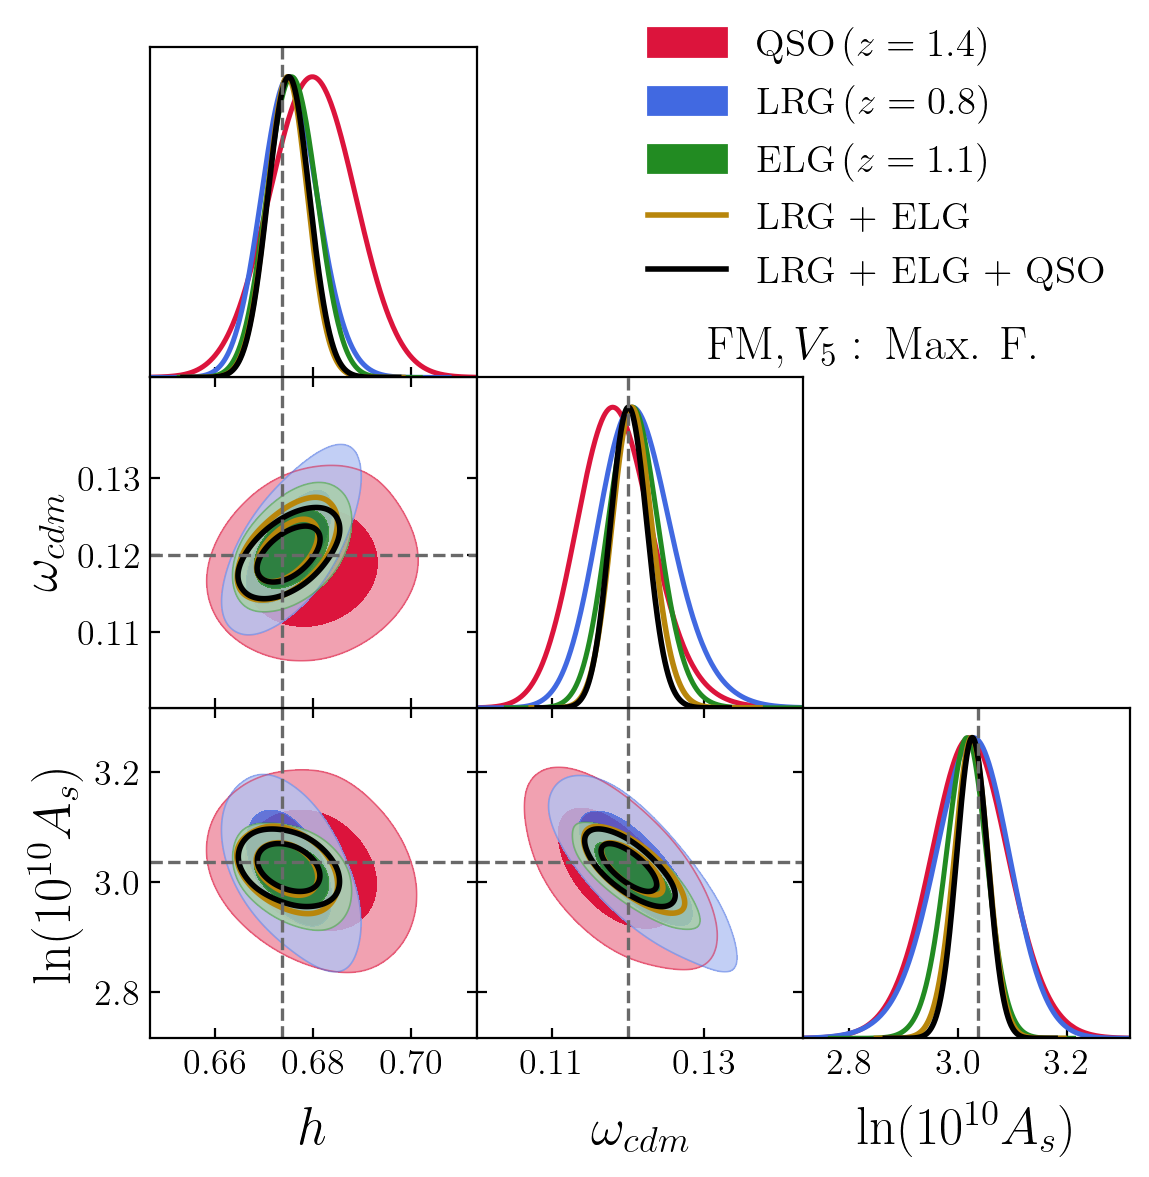

In [16]:
plot_triangular_chains(chains_and_labels=chains_and_labels_MaxF_V5, 
                       filled=filled, contour_ls=contour_ls, contour_lws=contour_lws,
                       legend_labels=legend_labels, contour_colors=contour_colors, markers=markers,
                       params_to_show=params_to_show,
                       title=r'$\textnormal{FM,}\,V_{5}:\,\textnormal{Max. F.}$',
                       fontsize_title=17, title_x=0.75, title_y=0.73, 
                       save_path='Plots/Base_FM_V5_MaxF.pdf',
                       smoothing=True, params_ranges=None, alpha_filled=0.8,
                       legend_fontsize = 17, 
                       legend_x=0.55, 
                       legend_y=0.74,
                       axes_labelsize=22, axes_fontsize=16, marker_color='dimgray')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


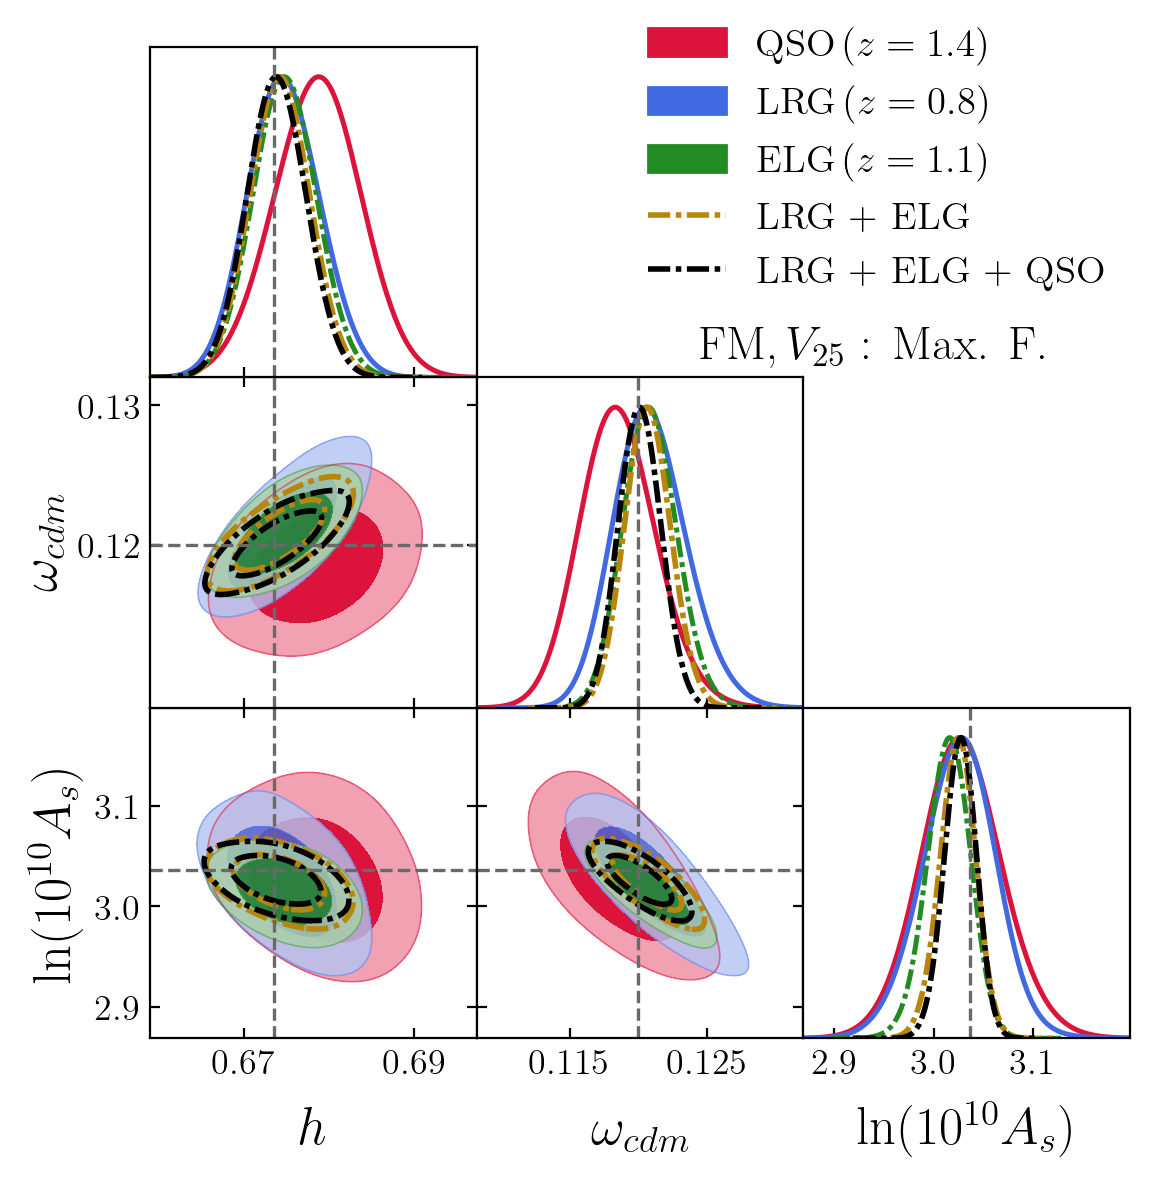

In [17]:
contour_ls = ['-', '-', '-.', '-.', '-.']
filled = [True, True, True, False, False]
contour_lws = [1.8, 1.8, 1.8, 2.0, 2.0]

plot_triangular_chains(chains_and_labels=chains_and_labels_MaxF_V25, 
                       filled=filled, contour_ls=contour_ls, contour_lws=contour_lws,
                       legend_labels=legend_labels, contour_colors=contour_colors, markers=markers,
                       params_to_show=params_to_show,
                       title=r'$\textnormal{FM,}\,V_{25}:\,\textnormal{Max. F.}$',
                       fontsize_title=17, title_x=0.75, title_y=0.73, 
                       save_path='Plots/Base_FM_V25_MaxF.pdf',
                       smoothing=True, params_ranges=None, alpha_filled=0.8,
                       legend_fontsize = 17, 
                       legend_x=0.55, 
                       legend_y=0.74,
                       axes_labelsize=22, axes_fontsize=16, marker_color='dimgray')

# 1D plots

In [18]:
def plot_1D_marginals(chains_and_labels, filled, contour_ls, contour_lws,
                           legend_labels, contour_colors, markers, params_to_show=None,
                           title=None, fontsize_title=None, title_x=None, title_y=None,
                           share_y=True, nx=3, legend_ncol=2,
                           save_path=None, smoothing=False, params_ranges=None, width_inch=10, legend_fontsize=12,
                           axes_labelsize =12,
                           legend_x = 0.0, legend_y=0.9, fontsize=12, ax=0, marker_color='k'):
    '''
    Generate a triangular plot for multiple chains of samples.

    Args:
        chains_and_labels (list of tuples): List of tuples where each tuple contains a numpy array representing the sample chain and its corresponding labels.
        filled (list): List of True or False for filled distributions or not. (...in construction...)
        contour_ls (list): List of line styles: '-', '--', '-.', ':'.
        contour_lws (list): List of line widths.
        legend_labels (list): Labels for the legends of each chain.
        contour_colors (list): List of colors to be used.
        markers (list): List of markers for each chain.
        params_to_show (list, optional): List of parameters to be shown in the plot. Default is None.
        title (str, optional): Title of the plot. Default is None.
        fontsize_title (float, optional): Font size for the plot title.
        title_x (float, optional): x-coordinate of the plot title.
        title_y (float, optional): y-coordinate of the plot title.
        share_y (bool): Whether to share the y-axis. Default is True.
        nx (int): Number of subplots in the x-axis. Default is 3.
        legend_ncol (int): Number of columns in the legend. Default is 2.
        save_path (str, optional): Path to save the plot image. Default is None.
        smoothing (bool, optional): Whether to apply smoothing to the samples. Default is False.
        params_ranges (dict, optional): Dictionary with parameter names as keys and corresponding ranges as values.

    Returns:
        beautiful 1D plots.
    '''

    # Create MCSamples instances for each chain and its labels
    samples = []
    for chain, labels in chains_and_labels:
        ranges = {}
        if params_ranges:
            for param, param_range in params_ranges.items():
                ranges[param] = param_range
        sample_instance = MCSamples(samples=chain, names=labels, ranges=ranges)
        samples.append(sample_instance)

    # If params_to_show is not provided, show all parameters
    if params_to_show is None:
        params_to_show = [labels for _, labels in chains_and_labels]

    # Apply smoothing if specified
    if smoothing:
        samples_smooth = [s.copy(settings={'mult_bias_correction_order': 1,
                                           'smooth_scale_2D': 0.7,
                                           'smooth_scale_1D': 0.7}) for s in samples]
    else:
        samples_smooth = samples

    # Plot settings
    g = plots.get_subplot_plotter(width_inch=width_inch)
    g.settings.figure_legend_frame = False
    g.settings.alpha_filled_add = 0.8
    g.settings.legend_fontsize = legend_fontsize #14
    g.settings.axes_labelsize = axes_labelsize #19
    g.settings.axes_fontsize = 26
    g.settings.axis_marker_color = marker_color
    g.settings.axis_marker_lw = 1.8
    
    
    # Generate the 1D plots with selected parameters
    g.plots_1d(samples_smooth, params_to_show,
               share_y=share_y, filled=filled,
               contour_ls=contour_ls,
               contour_lws=contour_lws,
               legend_labels=legend_labels,
               legend_loc='upper right',
               contour_colors=contour_colors,
               markers=markers,
               nx=nx, legend_ncol=legend_ncol,
               line_args=[{'ls': ls, 'lw': lw, 'color': color} for ls, lw, color in zip(contour_ls, contour_lws, contour_colors)]
              )
    
    #g.add_legend(legend_labels, legend_loc=((legend_x, legend_y)), legend_ncol=legend_ncol, fontsize=fontsize,
    #             ax=ax, colored_text=False);

    # Add title to the plot
    if title:
        plt.suptitle(title, fontsize=fontsize_title, x=title_x, y=title_y)

    # Save the plot to the specified path
    if save_path:
        plt.savefig(save_path, bbox_inches = 'tight')

    # Show the plot
    plt.show()

In [19]:
chains_and_labels_MaxF_MinF_V5_V25 = [
    (chain_MaxF_V5_ALL, labels_MaxF_ALL),
    (chain_MinF_V5_ALL, labels_MinF_ALL),
    (chain_MaxF_V25_ALL, labels_MaxF_ALL),
    (chain_MinF_V25_ALL, labels_MinF_ALL)
]

legend_labels = [
                 r'$\textnormal{$V_5$, Max. F.}$',
                 r'$\textnormal{$V_5$, Min. F.}$',
                 r'$\textnormal{$V_{25}$, Max. F.}$',
                 r'$\textnormal{$V_{25}$, Min. F.}$',
                ]

filled = [True, True, True, False, False]
contour_ls = ['-', '-', '-.', '-.', '-']
contour_lws = [1.8*2.2, 1.8*2.2, 1.8*2.2, 1.8*2.2, 1.8*2.2]
contour_colors = ['k', 'darkorange', 'k', 'darkorange', 'k']#['green', 'dimgrey','brown']

params_to_show = [r'$h$', r'$\omega_{cdm}$',r'$\ln(10^{10}A_s)$']

markers = {r'$h$':0.6736, 
             r'$\omega_b$':0.02237,
             r'$\omega_{cdm}$':0.12,
             r'$\Omega_m$': 0.3151918679932973, 
             r'$\ln(10^{10}A_s)$':np.log(10**10 * 2.0830e-9)}

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


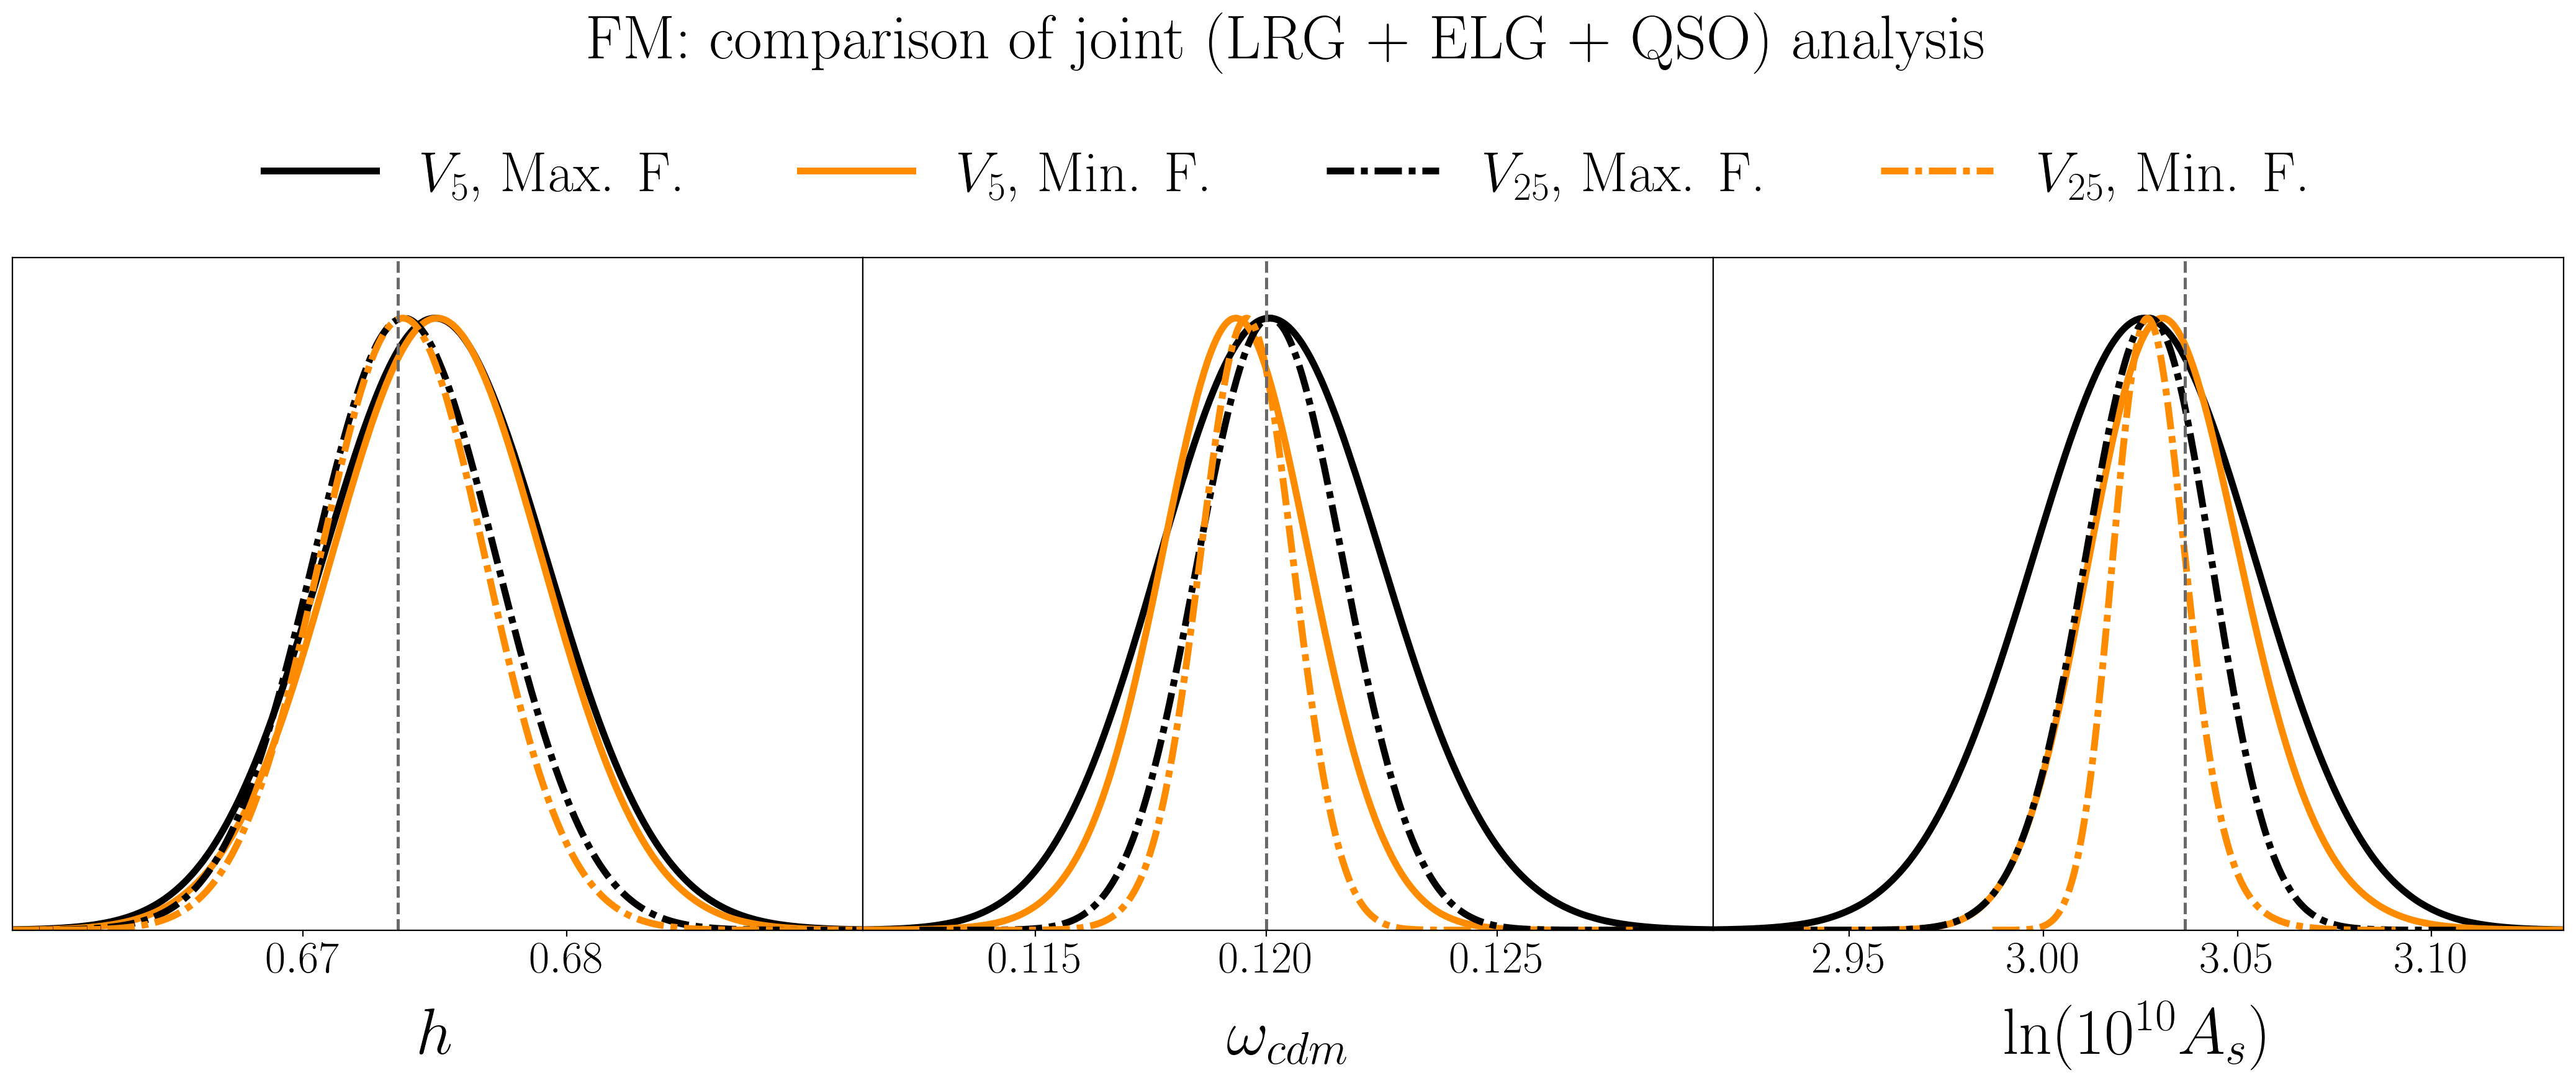

In [20]:
plot_1D_marginals(chains_and_labels_MaxF_MinF_V5_V25, filled, contour_ls, contour_lws,
                  legend_labels, contour_colors, markers, params_to_show=params_to_show,
                  title=r'$\textnormal{FM: comparison of  joint (LRG + ELG + QSO) analysis}$',
                  fontsize_title=36, title_x=0.5, title_y=1.25,
                  share_y=True, nx=3, legend_ncol=4,
                  save_path='Plots/Base_FM_1D.pdf', 
                  smoothing=True, params_ranges=None, width_inch=21, 
                  legend_fontsize=32.6, 
                  axes_labelsize=38,
                  fontsize=28, ax=0,
                  marker_color='dimgray')

# Horizontal plots

In [21]:
def get_param_stats(stats, param_index, stat_type = 'mean'):
    param_means = [stats[stat_type][param_index] for stats in stats]
    return np.array(param_means)

In [22]:
stats_MinF_V5 = get_stats_chains(chains=[chain_MinF_V5_LRG,
                                         chain_MinF_V5_ELG,
                                         chain_MinF_V5_QSO,
                                         chain_MinF_V5_LRG_ELG,
                                         chain_MinF_V5_ALL])

stats_MaxF_V5 = get_stats_chains(chains=[chain_MaxF_V5_LRG,
                                         chain_MaxF_V5_ELG,
                                         chain_MaxF_V5_QSO,
                                         chain_MaxF_V5_LRG_ELG,
                                         chain_MaxF_V5_ALL])

In [23]:
stats_MinF_V25 = get_stats_chains(chains=[chain_MinF_V25_LRG,
                                         chain_MinF_V25_ELG,
                                         chain_MinF_V25_QSO,
                                         chain_MinF_V25_LRG_ELG,
                                         chain_MinF_V25_ALL])

stats_MaxF_V25 = get_stats_chains(chains=[chain_MaxF_V25_LRG,
                                         chain_MaxF_V25_ELG,
                                         chain_MaxF_V25_QSO,
                                         chain_MaxF_V25_LRG_ELG,
                                         chain_MaxF_V25_ALL])

In [24]:
###############################          V 5            ###############################3

In [25]:
#means
h_means_MinF_V5 = get_param_stats(stats=stats_MinF_V5, param_index=0, stat_type='mean')
ocdm_means_MinF_V5 = get_param_stats(stats=stats_MinF_V5, param_index=1, stat_type='mean')
lnAs_means_MinF_V5 = get_param_stats(stats=stats_MinF_V5, param_index=3, stat_type='mean')

#err lower
h_err_lower_MinF_V5 = abs(get_param_stats(stats=stats_MinF_V5, param_index=0, stat_type='sigma-'))
ocdm_err_lower_MinF_V5 = abs(get_param_stats(stats=stats_MinF_V5, param_index=1, stat_type='sigma-'))
lnAs_err_lower_MinF_V5 = abs(get_param_stats(stats=stats_MinF_V5, param_index=3, stat_type='sigma-'))

#err upper
h_err_upper_MinF_V5 = abs(get_param_stats(stats=stats_MinF_V5, param_index=0, stat_type='sigma+'))
ocdm_err_upper_MinF_V5 = abs(get_param_stats(stats=stats_MinF_V5, param_index=1, stat_type='sigma+'))
lnAs_err_upper_MinF_V5 = abs(get_param_stats(stats=stats_MinF_V5, param_index=3, stat_type='sigma+'))

In [26]:
#means
h_means_MaxF_V5 = get_param_stats(stats=stats_MaxF_V5, param_index=0, stat_type='mean')
ocdm_means_MaxF_V5 = get_param_stats(stats=stats_MaxF_V5, param_index=1, stat_type='mean')
lnAs_means_MaxF_V5 = get_param_stats(stats=stats_MaxF_V5, param_index=3, stat_type='mean')

#err lower
h_err_lower_MaxF_V5 = abs(get_param_stats(stats=stats_MaxF_V5, param_index=0, stat_type='sigma-'))
ocdm_err_lower_MaxF_V5 = abs(get_param_stats(stats=stats_MaxF_V5, param_index=1, stat_type='sigma-'))
lnAs_err_lower_MaxF_V5 = abs(get_param_stats(stats=stats_MaxF_V5, param_index=3, stat_type='sigma-'))

#err upper
h_err_upper_MaxF_V5 = abs(get_param_stats(stats=stats_MaxF_V5, param_index=0, stat_type='sigma+'))
ocdm_err_upper_MaxF_V5 = abs(get_param_stats(stats=stats_MaxF_V5, param_index=1, stat_type='sigma+'))
lnAs_err_upper_MaxF_V5 = abs(get_param_stats(stats=stats_MaxF_V5, param_index=3, stat_type='sigma+'))

In [27]:
###############################          V  2 5            ###############################3

In [28]:
#means
h_means_MinF_V25 = get_param_stats(stats=stats_MinF_V25, param_index=0, stat_type='mean')
ocdm_means_MinF_V25 = get_param_stats(stats=stats_MinF_V25, param_index=1, stat_type='mean')
lnAs_means_MinF_V25 = get_param_stats(stats=stats_MinF_V25, param_index=3, stat_type='mean')

#err lower
h_err_lower_MinF_V25 = abs(get_param_stats(stats=stats_MinF_V25, param_index=0, stat_type='sigma-'))
ocdm_err_lower_MinF_V25 = abs(get_param_stats(stats=stats_MinF_V25, param_index=1, stat_type='sigma-'))
lnAs_err_lower_MinF_V25 = abs(get_param_stats(stats=stats_MinF_V25, param_index=3, stat_type='sigma-'))

#err upper
h_err_upper_MinF_V25 = abs(get_param_stats(stats=stats_MinF_V25, param_index=0, stat_type='sigma+'))
ocdm_err_upper_MinF_V25 = abs(get_param_stats(stats=stats_MinF_V25, param_index=1, stat_type='sigma+'))
lnAs_err_upper_MinF_V25 = abs(get_param_stats(stats=stats_MinF_V25, param_index=3, stat_type='sigma+'))

In [29]:
#means
h_means_MaxF_V25 = get_param_stats(stats=stats_MaxF_V25, param_index=0, stat_type='mean')
ocdm_means_MaxF_V25 = get_param_stats(stats=stats_MaxF_V25, param_index=1, stat_type='mean')
lnAs_means_MaxF_V25 = get_param_stats(stats=stats_MaxF_V25, param_index=3, stat_type='mean')

#err lower
h_err_lower_MaxF_V25 = abs(get_param_stats(stats=stats_MaxF_V25, param_index=0, stat_type='sigma-'))
ocdm_err_lower_MaxF_V25 = abs(get_param_stats(stats=stats_MaxF_V25, param_index=1, stat_type='sigma-'))
lnAs_err_lower_MaxF_V25 = abs(get_param_stats(stats=stats_MaxF_V25, param_index=3, stat_type='sigma-'))

#err upper
h_err_upper_MaxF_V25 = abs(get_param_stats(stats=stats_MaxF_V25, param_index=0, stat_type='sigma+'))
ocdm_err_upper_MaxF_V25 = abs(get_param_stats(stats=stats_MaxF_V25, param_index=1, stat_type='sigma+'))
lnAs_err_upper_MaxF_V25 = abs(get_param_stats(stats=stats_MaxF_V25, param_index=3, stat_type='sigma+'))

In [33]:
x = [r'$\textnormal{LRG}$',
     r'$\textnormal{ELG}$',
     r'$\textnormal{QSO}$',
     r'$\textnormal{LRG + ELG}$',
     r'$\textnormal{ALL}$']

x_ = [0.1, 1.1, 2.1, 3.1, 4.1]
x_plus = [x_ + 0.05 * 4 for x_ in x_]
x_plus_ = [x_ + 0.05 * 6 for x_ in x_]

## V5

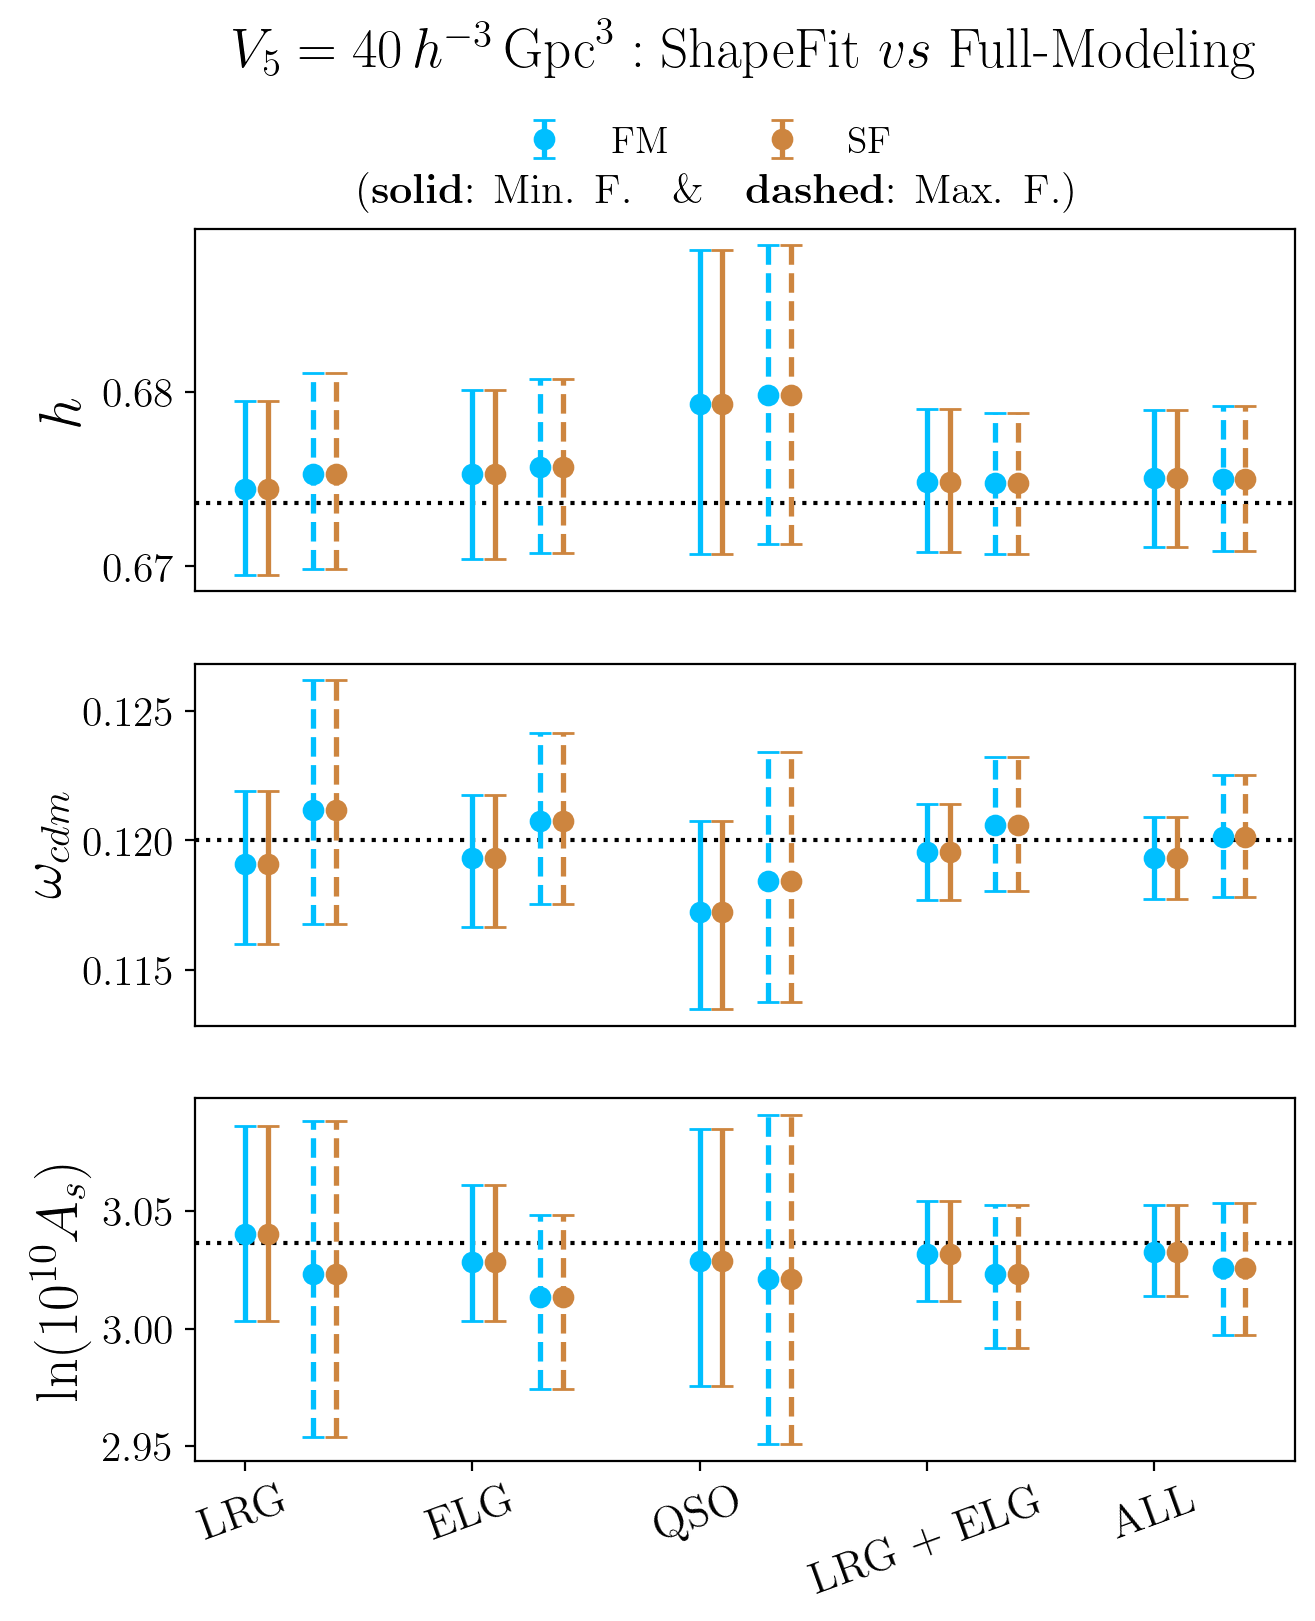

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


fig, axs = plt.subplots(3, 1,figsize=(7.1, 8), sharex=False, sharey=False)


axs[0].set_ylabel(r'$h$', fontsize =  21)
axs[1].set_ylabel(r'$\omega_{cdm}$', fontsize =  21)
axs[2].set_ylabel(r'$\ln(10^{10}A_s)$', fontsize =  21)



axs[0].axhline(y = 0.6736*1, color = 'k', linestyle = ':')

axs[1].axhline(y = 0.12, color = 'k', linestyle = ':') 

axs[2].axhline(y = np.log(10**10 * 2.0830e-9), color = 'k', linestyle = ':') 




#colors = ['crimson', 'royalblue', 'forestgreen', 'darkgoldenrod', 'k']


############################       V 5: Full - Modeling            #########################################

# V5  MinF

for ii in range(len(h_means_MinF_V5)):
    
    FM_h_MinF_V5 = axs[0].errorbar(x[ii], h_means_MinF_V5[ii], 
                yerr = [np.array([h_err_lower_MinF_V5[ii]]),
                         np.array([h_err_upper_MinF_V5[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    axs[1].errorbar(x[ii], ocdm_means_MinF_V5[ii], 
                yerr = [np.array([ocdm_err_lower_MinF_V5[ii]]),
                         np.array([ocdm_err_upper_MinF_V5[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    axs[2].errorbar(x[ii], lnAs_means_MinF_V5[ii], 
                yerr = [np.array([lnAs_err_lower_MinF_V5[ii]]),
                         np.array([lnAs_err_upper_MinF_V5[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
FM_h_MinF_V5.set_label(r'$\textnormal{FM}$')
    
    
#V5 Max F    
    
for ii in range(len(h_means_MaxF_V5)):
    
    FM_h_MaxF_V5 = axs[0].errorbar(x_plus[ii], h_means_MaxF_V5[ii], 
                yerr = [np.array([h_err_lower_MaxF_V5[ii]]),
                         np.array([h_err_upper_MaxF_V5[ii]])],
                color = 'deepskyblue',
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    FM_ocdm_MaxF_V5 = axs[1].errorbar(x_plus[ii], ocdm_means_MaxF_V5[ii], 
                yerr = [np.array([ocdm_err_lower_MaxF_V5[ii]]),
                         np.array([ocdm_err_upper_MaxF_V5[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    FM_lnAs_MaxF_V5 = axs[2].errorbar(x_plus[ii], lnAs_means_MaxF_V5[ii], 
                yerr = [np.array([lnAs_err_lower_MaxF_V5[ii]]),
                         np.array([lnAs_err_upper_MaxF_V5[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    FM_h_MaxF_V5[-1][0].set_linestyle('--')
    FM_ocdm_MaxF_V5[-1][0].set_linestyle('--')
    FM_lnAs_MaxF_V5[-1][0].set_linestyle('--')
    

    
    

############################       V 5: ShapeFit            #########################################

# V5  MinF

for ii in range(len(h_means_MinF_V5)):
    
    SF_h_MinF_V5 = axs[0].errorbar(x_[ii], h_means_MinF_V5[ii], 
                yerr = [np.array([h_err_lower_MinF_V5[ii]]),
                         np.array([h_err_upper_MinF_V5[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    axs[1].errorbar(x_[ii], ocdm_means_MinF_V5[ii], 
                yerr = [np.array([ocdm_err_lower_MinF_V5[ii]]),
                         np.array([ocdm_err_upper_MinF_V5[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    axs[2].errorbar(x_[ii], lnAs_means_MinF_V5[ii], 
                yerr = [np.array([lnAs_err_lower_MinF_V5[ii]]),
                         np.array([lnAs_err_upper_MinF_V5[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
SF_h_MinF_V5.set_label(r'$\textnormal{SF}$')
    
    
    
#V5 Max F    
    
for ii in range(len(h_means_MaxF_V5)):
    
    SF_h_MaxF_V5 = axs[0].errorbar(x_plus_[ii], h_means_MaxF_V5[ii], 
                yerr = [np.array([h_err_lower_MaxF_V5[ii]]),
                         np.array([h_err_upper_MaxF_V5[ii]])],
                color = 'peru',
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    SF_ocdm_MaxF_V5 = axs[1].errorbar(x_plus_[ii], ocdm_means_MaxF_V5[ii], 
                yerr = [np.array([ocdm_err_lower_MaxF_V5[ii]]),
                         np.array([ocdm_err_upper_MaxF_V5[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    SF_lnAs_MaxF_V5 = axs[2].errorbar(x_plus_[ii], lnAs_means_MaxF_V5[ii], 
                yerr = [np.array([lnAs_err_lower_MaxF_V5[ii]]),
                         np.array([lnAs_err_upper_MaxF_V5[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    SF_h_MaxF_V5[-1][0].set_linestyle('--')
    SF_ocdm_MaxF_V5[-1][0].set_linestyle('--')
    SF_lnAs_MaxF_V5[-1][0].set_linestyle('--')
    
    
    


    
axs[0].set_xticks([]);
axs[1].set_xticks([]);
#axs[2].set_xticklabels(axs[2].get_xticks(), rotation=45);
plt.xticks(rotation = 20, fontsize=16);

leg1 = axs[0].legend(loc = ((0.27),(1.15)), fontsize = 13.5, ncol = 2);
leg1.get_frame().set_linewidth(0.0);


plt.title(r'$V_{5} = 40\, h^{-3}\, \textnormal{Gpc}^3: \textnormal{ShapeFit $vs$ Full-Modeling}$', 
          fontsize=20, y = 3.8, x = 0.5)

plt.text(x=0.5, y=3.48, s=r'$\textnormal{(\textbf{solid}: Min. F. \,\, \& \,\, \textbf{dashed}: Max. F.)}$')

plt.savefig('Plots/Base_summary_V5.pdf', bbox_inches = 'tight')

plt.show()

#### \textnormal{(\textbf{solid}: Min. F. \,\, \& \,\, \textbf{dashed}: Max. F.)}

## V25

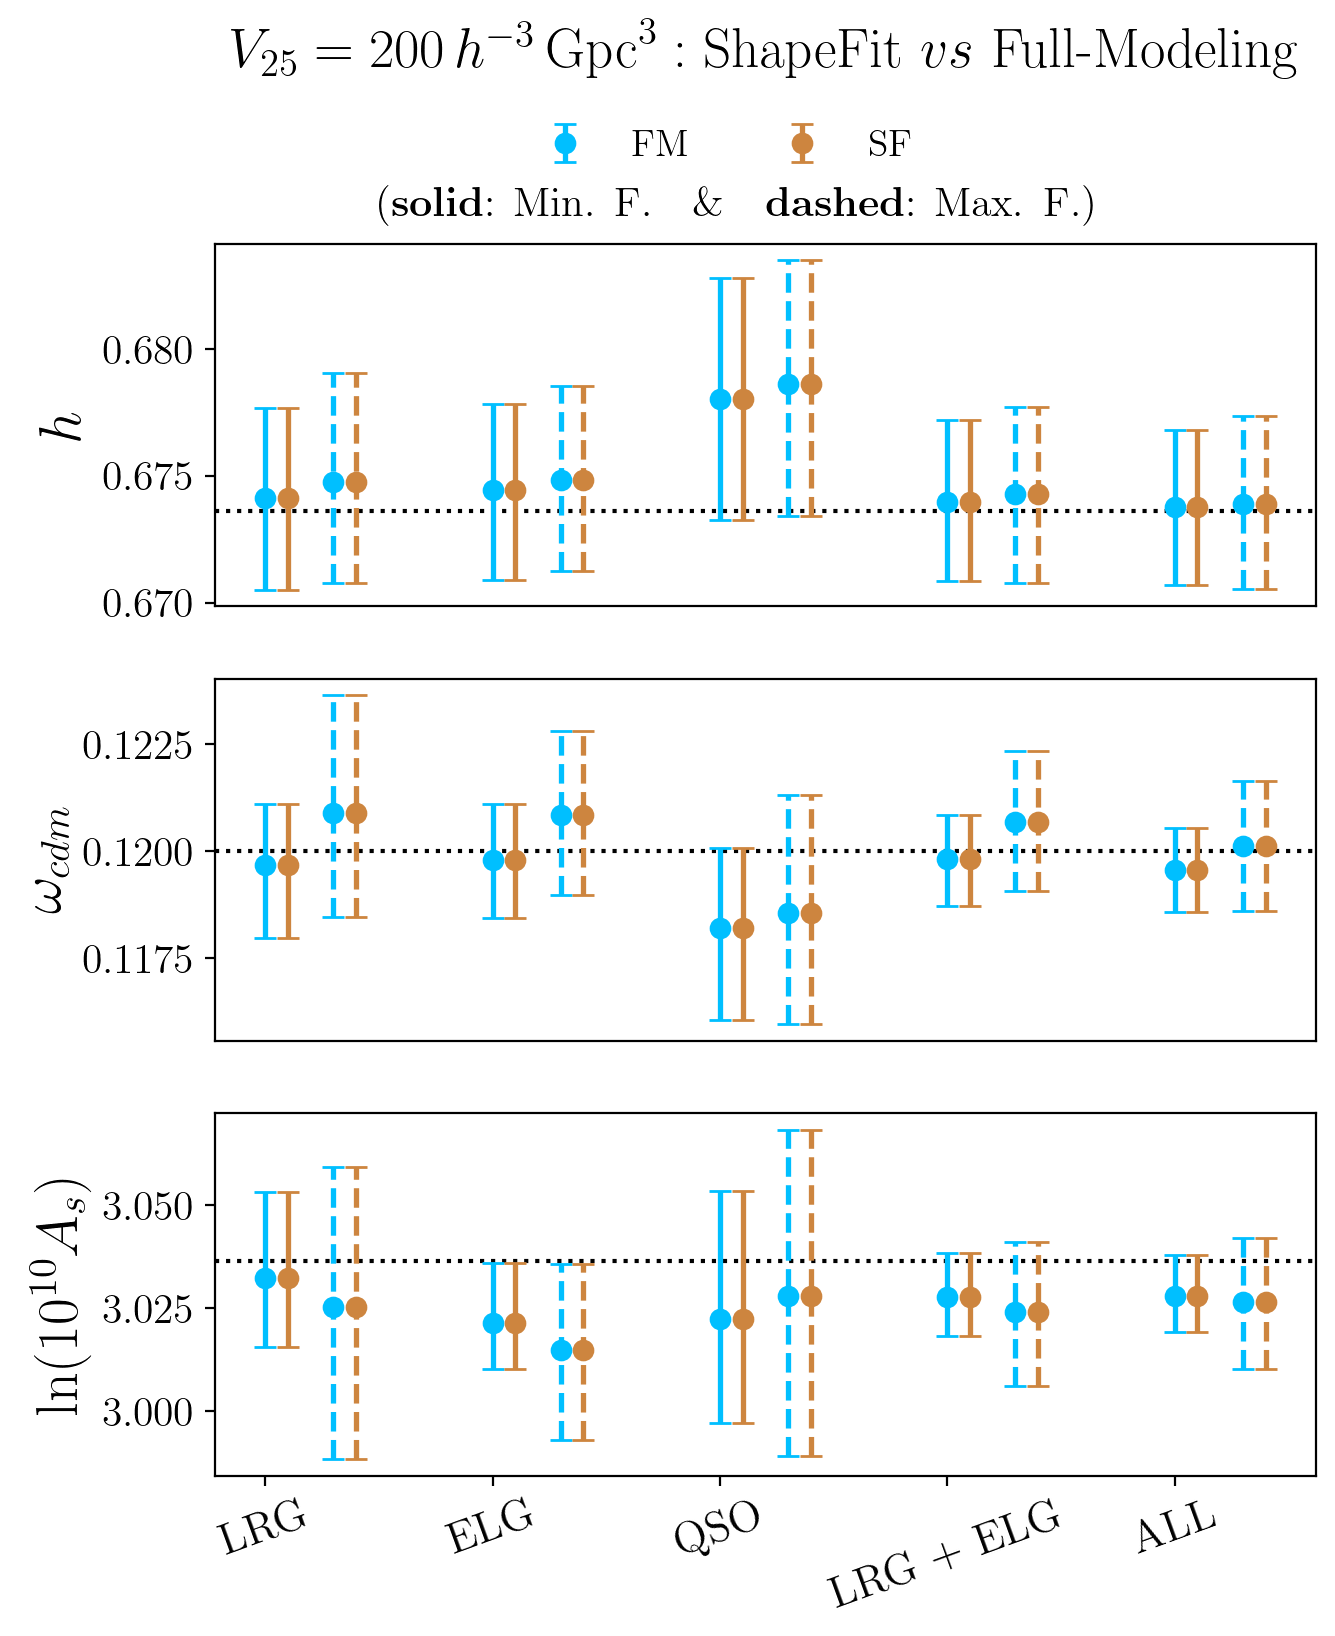

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


fig, axs = plt.subplots(3, 1,figsize=(7.1, 8), sharex=False, sharey=False)


axs[0].set_ylabel(r'$h$', fontsize =  21)
axs[1].set_ylabel(r'$\omega_{cdm}$', fontsize =  21)
axs[2].set_ylabel(r'$\ln(10^{10}A_s)$', fontsize =  21)



axs[0].axhline(y = 0.6736*1, color = 'k', linestyle = ':')

axs[1].axhline(y = 0.12, color = 'k', linestyle = ':') 

axs[2].axhline(y = np.log(10**10 * 2.0830e-9), color = 'k', linestyle = ':') 




#colors = ['crimson', 'royalblue', 'forestgreen', 'darkgoldenrod', 'k']


############################       V 5: Full - Modeling            #########################################

# V25  MinF

for ii in range(len(h_means_MinF_V25)):
    
    FM_h_MinF_V25 = axs[0].errorbar(x[ii], h_means_MinF_V25[ii], 
                yerr = [np.array([h_err_lower_MinF_V25[ii]]),
                         np.array([h_err_upper_MinF_V25[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    axs[1].errorbar(x[ii], ocdm_means_MinF_V25[ii], 
                yerr = [np.array([ocdm_err_lower_MinF_V25[ii]]),
                         np.array([ocdm_err_upper_MinF_V25[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    axs[2].errorbar(x[ii], lnAs_means_MinF_V25[ii], 
                yerr = [np.array([lnAs_err_lower_MinF_V25[ii]]),
                         np.array([lnAs_err_upper_MinF_V25[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
FM_h_MinF_V25.set_label(r'$\textnormal{FM}$')
    
    
#V25 Max F    
    
for ii in range(len(h_means_MaxF_V25)):
    
    FM_h_MaxF_V25 = axs[0].errorbar(x_plus[ii], h_means_MaxF_V25[ii], 
                yerr = [np.array([h_err_lower_MaxF_V25[ii]]),
                         np.array([h_err_upper_MaxF_V25[ii]])],
                color = 'deepskyblue',
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    FM_ocdm_MaxF_V25 = axs[1].errorbar(x_plus[ii], ocdm_means_MaxF_V25[ii], 
                yerr = [np.array([ocdm_err_lower_MaxF_V25[ii]]),
                         np.array([ocdm_err_upper_MaxF_V25[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    FM_lnAs_MaxF_V25 = axs[2].errorbar(x_plus[ii], lnAs_means_MaxF_V25[ii], 
                yerr = [np.array([lnAs_err_lower_MaxF_V25[ii]]),
                         np.array([lnAs_err_upper_MaxF_V25[ii]])],
                color = 'deepskyblue', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    FM_h_MaxF_V25[-1][0].set_linestyle('--')
    FM_ocdm_MaxF_V25[-1][0].set_linestyle('--')
    FM_lnAs_MaxF_V25[-1][0].set_linestyle('--')
    

    
    

############################       V 5: ShapeFit            #########################################

# V25  MinF

for ii in range(len(h_means_MinF_V25)):
    
    SF_h_MinF_V25 = axs[0].errorbar(x_[ii], h_means_MinF_V25[ii], 
                yerr = [np.array([h_err_lower_MinF_V25[ii]]),
                         np.array([h_err_upper_MinF_V25[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    axs[1].errorbar(x_[ii], ocdm_means_MinF_V25[ii], 
                yerr = [np.array([ocdm_err_lower_MinF_V25[ii]]),
                         np.array([ocdm_err_upper_MinF_V25[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    axs[2].errorbar(x_[ii], lnAs_means_MinF_V25[ii], 
                yerr = [np.array([lnAs_err_lower_MinF_V25[ii]]),
                         np.array([lnAs_err_upper_MinF_V25[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
SF_h_MinF_V25.set_label(r'$\textnormal{SF}$')
    
    
    
#V25 Max F    
    
for ii in range(len(h_means_MaxF_V25)):
    
    SF_h_MaxF_V25 = axs[0].errorbar(x_plus_[ii], h_means_MaxF_V25[ii], 
                yerr = [np.array([h_err_lower_MaxF_V25[ii]]),
                         np.array([h_err_upper_MaxF_V25[ii]])],
                color = 'peru',
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    SF_ocdm_MaxF_V25 = axs[1].errorbar(x_plus_[ii], ocdm_means_MaxF_V25[ii], 
                yerr = [np.array([ocdm_err_lower_MaxF_V25[ii]]),
                         np.array([ocdm_err_upper_MaxF_V25[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    
    SF_lnAs_MaxF_V25 = axs[2].errorbar(x_plus_[ii], lnAs_means_MaxF_V25[ii], 
                yerr = [np.array([lnAs_err_lower_MaxF_V25[ii]]),
                         np.array([lnAs_err_upper_MaxF_V25[ii]])],
                color = 'peru', 
                fmt='o', capsize = 4,lw = 1.9,  markersize=6.8);
    
    SF_h_MaxF_V25[-1][0].set_linestyle('--')
    SF_ocdm_MaxF_V25[-1][0].set_linestyle('--')
    SF_lnAs_MaxF_V25[-1][0].set_linestyle('--')
    
    
    


    
axs[0].set_xticks([]);
axs[1].set_xticks([]);
#axs[2].set_xticklabels(axs[2].get_xticks(), rotation=45);
plt.xticks(rotation = 20, fontsize=16);

leg1 = axs[0].legend(loc = ((0.27),(1.18)), fontsize = 13.5, ncol = 2);
leg1.get_frame().set_linewidth(0.0);


plt.title(r'$V_{25} = 200\, h^{-3}\, \textnormal{Gpc}^3: \textnormal{ShapeFit $vs$ Full-Modeling}$', 
          fontsize=20, y = 3.84, x = 0.5)

plt.text(x=0.5, y=3.290, s=r'$\textnormal{(\textbf{solid}: Min. F. \,\, \& \,\, \textbf{dashed}: Max. F.)}$')

plt.savefig('Plots/Base_summary_V25.pdf', bbox_inches = 'tight')

plt.show()